In [5]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.3 MB/s eta 0:00:00


In [6]:
from google.colab import drive #import drive from google.colab
drive.mount('/content/drive') #mount google drive

Mounted at /content/drive


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
import random
import os

In [9]:
def train_test_split(data):
  train_size = int(len(data)*0.5)
  xtrain, xtest = data[:train_size], data[train_size:]
  return xtrain, xtest

def auto_model(xtrain):
  optimal_model = auto_arima(xtrain[:, 0],
                        exogenous= xtrain[:, 1:],
                        seasonal=False,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)
  return optimal_model

def sarimax_model (xtrain, order, seasonal_order):
  sarimax_model = SARIMAX(xtrain[:, 0],
                        exog=xtrain[:, 1:],
                        order = order,
                        seasonal_order = seasonal_order)
  return sarimax_model

def create_sequence(df, step):
  X = []
  Y = []
  for i in range(len(df)):
    end_index = i+step
    if end_index > len(df)-1:
      break
    x_value = df[i:end_index, :]
    y_value = df[end_index, 0]
    X.append(x_value)
    Y.append(y_value)
  return np.array(X), np.array(Y)

def reinitialize(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.LSTM):
            for weight in layer.weights:
                if 'kernel' in weight.name:
                    weight.assign(tf.keras.initializers.GlorotUniform()(weight.shape))
                elif 'recurrent_kernel' in weight.name:
                    weight.assign(tf.keras.initializers.Orthogonal()(weight.shape))
                elif 'bias' in weight.name:
                    weight.assign(tf.keras.initializers.Zeros()(weight.shape))
        elif isinstance(layer, tf.keras.layers.Dense):
            layer.kernel.assign(tf.keras.initializers.GlorotUniform()(layer.kernel.shape))
            if layer.bias is not None:
                layer.bias.assign(tf.keras.initializers.Zeros()(layer.bias.shape))

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seeds()


In [10]:
cluster_df = pd.read_excel('/content/drive/MyDrive/final_project/EML_forecast/clustered_forecast_data.xlsx').drop(columns=['Unnamed: 0'])

In [11]:
print(cluster_df.head())

        Year      Country   Emission  Fertlizer_consumption  Temperature  \
0 1961-01-01  Afghanistan  2917273.5                   0.13    11.336061   
1 1962-01-01  Afghanistan  2891160.8                   0.13    11.144664   
2 1963-01-01  Afghanistan  2941533.2                   0.13    12.411098   
3 1964-01-01  Afghanistan  3004207.0                   0.13    10.428792   
4 1965-01-01  Afghanistan  3075739.0                   0.13    11.212704   

   Cluster  
0        0  
1        0  
2        0  
3        0  
4        0  


In [12]:
china_df = cluster_df[cluster_df['Country']=='China'].drop(columns=['Cluster', 'Country'])
china_df.set_index('Year', inplace=True)

In [13]:
us_df = cluster_df[cluster_df['Country']=='United States'].drop(columns=['Cluster', 'Country'])
us_df.set_index('Year', inplace=True)

In [9]:
for col in china_df.columns:
    result = adfuller(china_df[col])
    print('p-value:', result[1])

p-value: 0.43705876632596996
p-value: 0.3591085281434667
p-value: 0.9830421590144939


In [10]:
for col in us_df.columns:
    result = adfuller(us_df[col])
    print('p-value:', result[1])

p-value: 0.00013000309999711617
p-value: 0.027588015851474086
p-value: 0.8604558151280166


In [14]:
china_scaler = StandardScaler()
scaled_china_df = china_scaler.fit_transform(china_df[['Emission', 'Fertlizer_consumption', 'Temperature']])
print(scaled_china_df)

[[-1.639809   -1.72974923 -0.49242438]
 [-1.61894212 -1.69508566 -1.05668443]
 [-1.57558301 -1.6736401  -0.56592807]
 [-1.51535014 -1.63762775 -0.7787163 ]
 [-1.45578867 -1.56155672 -1.02151465]
 [-1.3780741  -1.45095699 -0.98733475]
 [-1.37787268 -1.54307847 -1.74241199]
 [-1.35103239 -1.51731683 -1.18818726]
 [-1.31729768 -1.45163138 -1.36795121]
 [-1.26264032 -1.35276601 -1.43526576]
 [-1.23038446 -1.35114748 -0.99923788]
 [-1.17725094 -1.28397838 -1.10531926]
 [-1.12197311 -1.20251224 -0.45582215]
 [-1.11911698 -1.28654106 -1.16680471]
 [-1.04687308 -1.11834854 -0.34749137]
 [-1.04495905 -1.1561143  -1.4770527 ]
 [-0.91353138 -0.84117483 -1.10064841]
 [-0.77011885 -0.54066728 -0.54920639]
 [-0.68268482 -0.3553453  -0.5782699 ]
 [-0.57475211 -0.15491701 -0.75116722]
 [-0.62913948 -0.2451502  -0.7027838 ]
 [-0.57869966 -0.22330001 -0.34416606]
 [-0.47516172 -0.12969488 -0.85620317]
 [-0.3792029  -0.06198626 -1.24103514]
 [-0.43765434 -0.30678932 -1.13895411]
 [-0.40950305 -0.35251286

In [12]:
xtrain,xtest = train_test_split(scaled_china_df)

In [13]:
optimal_model = auto_model(xtrain)
print(optimal_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-76.581, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.755, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.823, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-79.913, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.988, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.044 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  42.878
Date:                Sun, 28 Jul 2024   AIC                            -81.755
Time:                        11:10:47   BIC                            -79.021
Sample:                             0   HQIC                           -80.899
                    

In [14]:
order = optimal_model.order
seasonal_order = optimal_model.seasonal_order
sarimax_model1 = sarimax_model(xtrain, order, seasonal_order)
sarimax_model1_fit = sarimax_model1.fit()

In [15]:
sarimax_model1_forecast = sarimax_model1_fit.forecast(steps=len(xtest),
                             exog=xtest[:, 1:])

In [16]:
sarimax_model1_mse = mean_squared_error(xtest[:, 0], sarimax_model1_forecast)
sarimax_model1_rmse = np.sqrt(sarimax_model1_mse)
sarimax_model1_mape = mean_absolute_percentage_error(xtest[:, 0], sarimax_model1_forecast)
print("RMSE : ",sarimax_model1_rmse)
print("MAPE : ",sarimax_model1_mape)

RMSE :  0.5594077695219328
MAPE :  0.5890808796591636


In [17]:
sarimax_model1_forecast = sarimax_model1_forecast.reshape(sarimax_model1_forecast.shape[0], -1)

In [18]:
forecast_copy = np.repeat(sarimax_model1_forecast, 3, axis=-1)
unscaled_sarimax_model1_forecast = china_scaler.inverse_transform(forecast_copy)[:, 0]

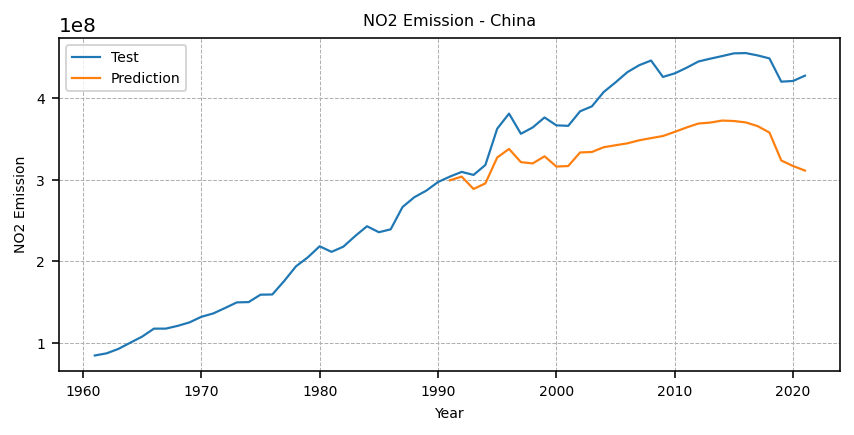

In [19]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(china_df.index, china_df['Emission'], label="Test",
            linewidth = 1.1)
plt.plot(china_df.index[len(xtrain):], unscaled_sarimax_model1_forecast, label='Prediction',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - China", fontsize=8)
plt.show()


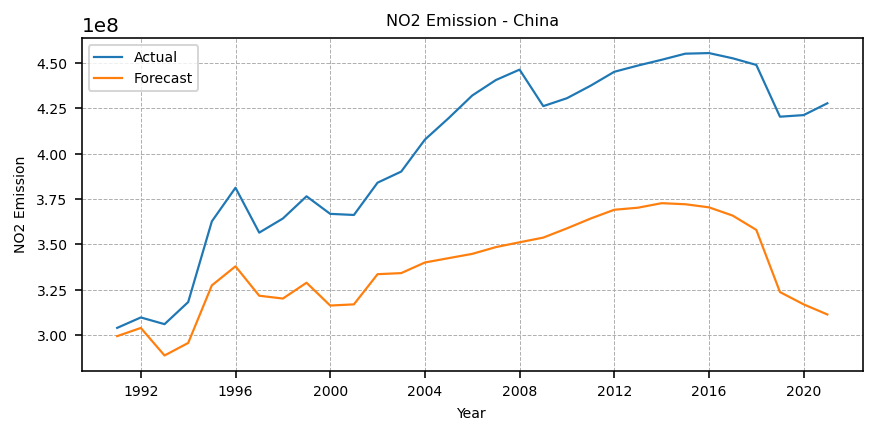

In [20]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(china_df.index[len(xtrain):], china_df.iloc[len(xtrain):]['Emission'], label="Actual",
            linewidth = 1.1)
plt.plot(china_df.index[len(xtrain):], unscaled_sarimax_model1_forecast, label='Forecast',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - China", fontsize=8)
plt.show()

In [15]:
us_scaler = StandardScaler()
scaled_us_df = us_scaler.fit_transform(us_df[['Emission', 'Fertlizer_consumption', 'Temperature']])
print(scaled_us_df)

[[-3.3456788  -2.43534799 -1.1749111 ]
 [-2.81988293 -2.26043599 -0.68877155]
 [-2.17680172 -2.12885805 -0.48591404]
 [-1.62292749 -2.01146216 -1.2916514 ]
 [-0.962459   -1.82630756 -1.15676182]
 [-0.36953665 -1.58994    -1.32442176]
 [ 0.29827587 -1.33623881 -0.76590404]
 [ 0.71278535 -1.29763211 -1.26237015]
 [ 1.08545013 -1.27320746 -0.90159904]
 [ 0.69645169 -1.08174973 -0.99552802]
 [ 0.84735106 -1.02974886 -1.38375216]
 [ 1.07784921 -0.977748   -1.46599085]
 [ 1.59844289 -0.76895665 -0.5744866 ]
 [ 1.27000237 -0.78786605 -0.68436286]
 [ 1.34399846 -0.47507298 -1.34626189]
 [ 2.09103745 -0.24500854 -1.06227765]
 [ 1.84009271 -0.36398022 -0.06346978]
 [ 1.88873733 -0.3174946  -0.89086899]
 [ 1.76165074 -0.103188   -1.02621993]
 [ 1.09326221  0.06936032 -0.24707545]
 [ 0.90589161 -0.06852076  0.64381105]
 [ 0.06320791 -0.52234649 -1.20783472]
 [ 0.27225744 -0.31040357 -0.55596667]
 [ 0.4812825  -0.03385352 -0.80929966]
 [ 0.12416846 -0.20955341 -1.091806  ]
 [-0.19845609 -0.35925287

In [22]:
xtrain,xtest = train_test_split(scaled_us_df)

In [23]:
optimal_model = auto_model(xtrain)
print(optimal_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=105.974, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=42.918, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=78.558, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=39.301, Time=0.42 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=38.739, Time=1.47 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=38.339, Time=1.83 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=40.105, Time=1.91 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=40.567, Time=0.58 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.37 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=42.233, Time=0.54 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=39.765, Time=0.44 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0]          
Total fit time: 10.451 seconds
                               SARIMAX Results                                
Dep. Variable:                      y

In [24]:
order = optimal_model.order
seasonal_order = optimal_model.seasonal_order
sarimax_model2 = sarimax_model(xtrain, order, seasonal_order)
sarimax_model2_fit = sarimax_model2.fit()

In [25]:
sarimax_model2_forecast = sarimax_model2_fit.forecast(steps=len(xtest),
                             exog=xtest[:, 1:])

In [26]:
sarimax_model2_mse = mean_squared_error(xtest[:, 0], sarimax_model2_forecast)
sarimax_model2_rmse = np.sqrt(sarimax_model2_mse)
sarimax_model2_mape = mean_absolute_percentage_error(xtest[:, 0], sarimax_model2_forecast)
print("RMSE : ",sarimax_model2_rmse)
print("MAPE : ",sarimax_model2_mape)

RMSE :  1.0433494365028964
MAPE :  9.170794320019194


In [27]:
sarimax_model2_forecast = sarimax_model2_forecast.reshape(sarimax_model1_forecast.shape[0], -1)

In [28]:
forecast_copy = np.repeat(sarimax_model2_forecast, 3, axis=-1)
unscaled_sarimax_model2_forecast = us_scaler.inverse_transform(forecast_copy)[:, 0]

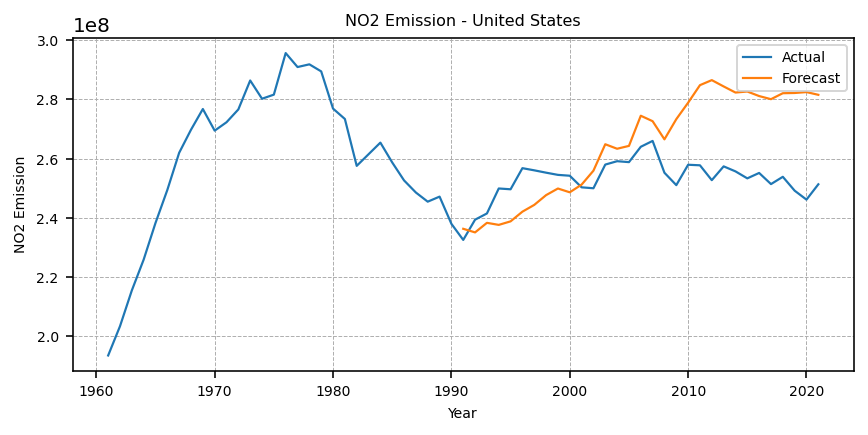

In [29]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(us_df.index, us_df['Emission'], label="Actual",
            linewidth = 1.1)
plt.plot(us_df.index[len(xtrain):], unscaled_sarimax_model2_forecast, label='Forecast',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - United States", fontsize=8)
plt.show()

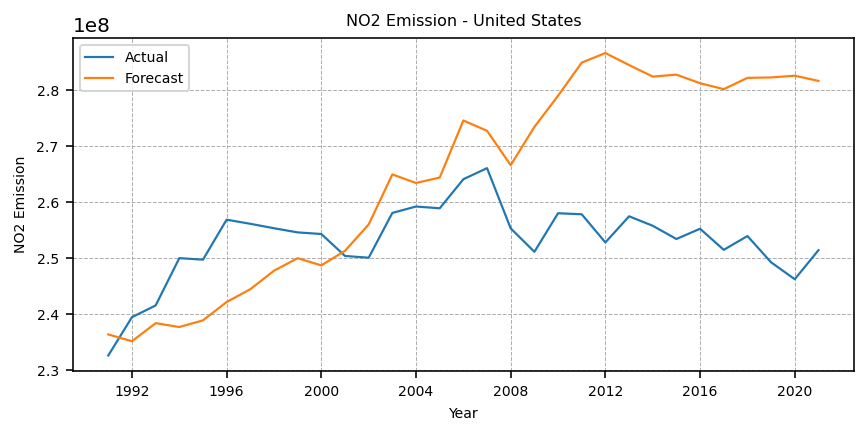

In [30]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(us_df.index[len(xtrain):], us_df.iloc[len(xtrain):]['Emission'], label="Actual",
            linewidth = 1.1)
plt.plot(us_df.index[len(xtrain):], unscaled_sarimax_model2_forecast, label='Forecast',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - United States", fontsize=8)
plt.show()

In [31]:
x, y = create_sequence(scaled_china_df, 5)
print(x)
print(y)

[[[-1.639809   -1.72974923 -0.49242438]
  [-1.61894212 -1.69508566 -1.05668443]
  [-1.57558301 -1.6736401  -0.56592807]
  [-1.51535014 -1.63762775 -0.7787163 ]
  [-1.45578867 -1.56155672 -1.02151465]]

 [[-1.61894212 -1.69508566 -1.05668443]
  [-1.57558301 -1.6736401  -0.56592807]
  [-1.51535014 -1.63762775 -0.7787163 ]
  [-1.45578867 -1.56155672 -1.02151465]
  [-1.3780741  -1.45095699 -0.98733475]]

 [[-1.57558301 -1.6736401  -0.56592807]
  [-1.51535014 -1.63762775 -0.7787163 ]
  [-1.45578867 -1.56155672 -1.02151465]
  [-1.3780741  -1.45095699 -0.98733475]
  [-1.37787268 -1.54307847 -1.74241199]]

 [[-1.51535014 -1.63762775 -0.7787163 ]
  [-1.45578867 -1.56155672 -1.02151465]
  [-1.3780741  -1.45095699 -0.98733475]
  [-1.37787268 -1.54307847 -1.74241199]
  [-1.35103239 -1.51731683 -1.18818726]]

 [[-1.45578867 -1.56155672 -1.02151465]
  [-1.3780741  -1.45095699 -0.98733475]
  [-1.37787268 -1.54307847 -1.74241199]
  [-1.35103239 -1.51731683 -1.18818726]
  [-1.31729768 -1.45163138 -1.36

In [32]:
train_size = int(len(x)*0.5)
x_train, x_test = x[:train_size], x[train_size: ]
y_train, y_test = y[:train_size], y[train_size: ]

In [73]:
lstm_model1 = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    tf.keras.layers.LSTM(32, activation = 'relu', return_sequences=False),
    tf.keras.layers.Dense(1)
])

In [34]:
optimizers = ['SGD', 'adam', 'RMSprop']
learning_rate = np.linspace(0.0001, 0.01, 4)
hist = []
for opt in optimizers:
  for rate in learning_rate:
      reinitialize(lstm_model1)
      lstm_model1.compile(optimizer=opt, loss='mse',  metrics=['mae'])
      lstm_model1.optimizer.learning_rate = rate
      print("")
      print(f"optimizer: {opt}    learning rate: {rate}")
      print("")
      history = lstm_model1.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=100)
      hist.append(history)


optimizer: SGD    learning rate: 0.0001

Epoch 1/100
1/1 [==============================] - 9s 9s/step - loss: 0.7535 - mae: 0.7286 - val_loss: 1.0558 - val_mae: 0.9816
Epoch 2/100
1/1 [==============================] - 0s 95ms/step - loss: 0.7532 - mae: 0.7285 - val_loss: 1.0561 - val_mae: 0.9817
Epoch 3/100
1/1 [==============================] - 0s 224ms/step - loss: 0.7530 - mae: 0.7284 - val_loss: 1.0564 - val_mae: 0.9819
Epoch 4/100
1/1 [==============================] - 0s 81ms/step - loss: 0.7528 - mae: 0.7282 - val_loss: 1.0567 - val_mae: 0.9820
Epoch 5/100
1/1 [==============================] - 0s 83ms/step - loss: 0.7525 - mae: 0.7281 - val_loss: 1.0570 - val_mae: 0.9822
Epoch 6/100
1/1 [==============================] - 0s 76ms/step - loss: 0.7523 - mae: 0.7280 - val_loss: 1.0573 - val_mae: 0.9823
Epoch 7/100
1/1 [==============================] - 0s 82ms/step - loss: 0.7520 - mae: 0.7279 - val_loss: 1.0576 - val_mae: 0.9825
Epoch 8/100
1/1 [==============================] 

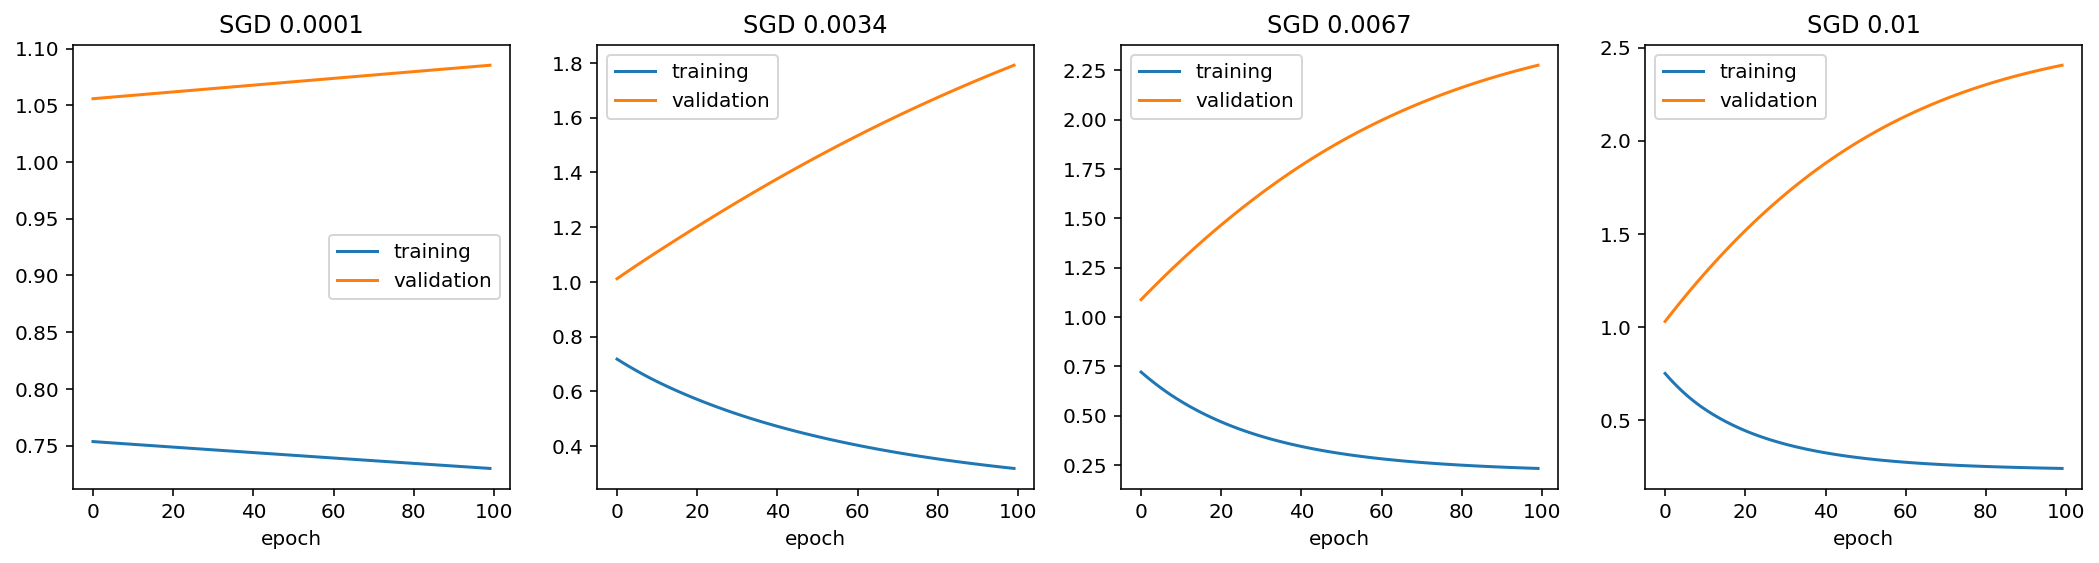

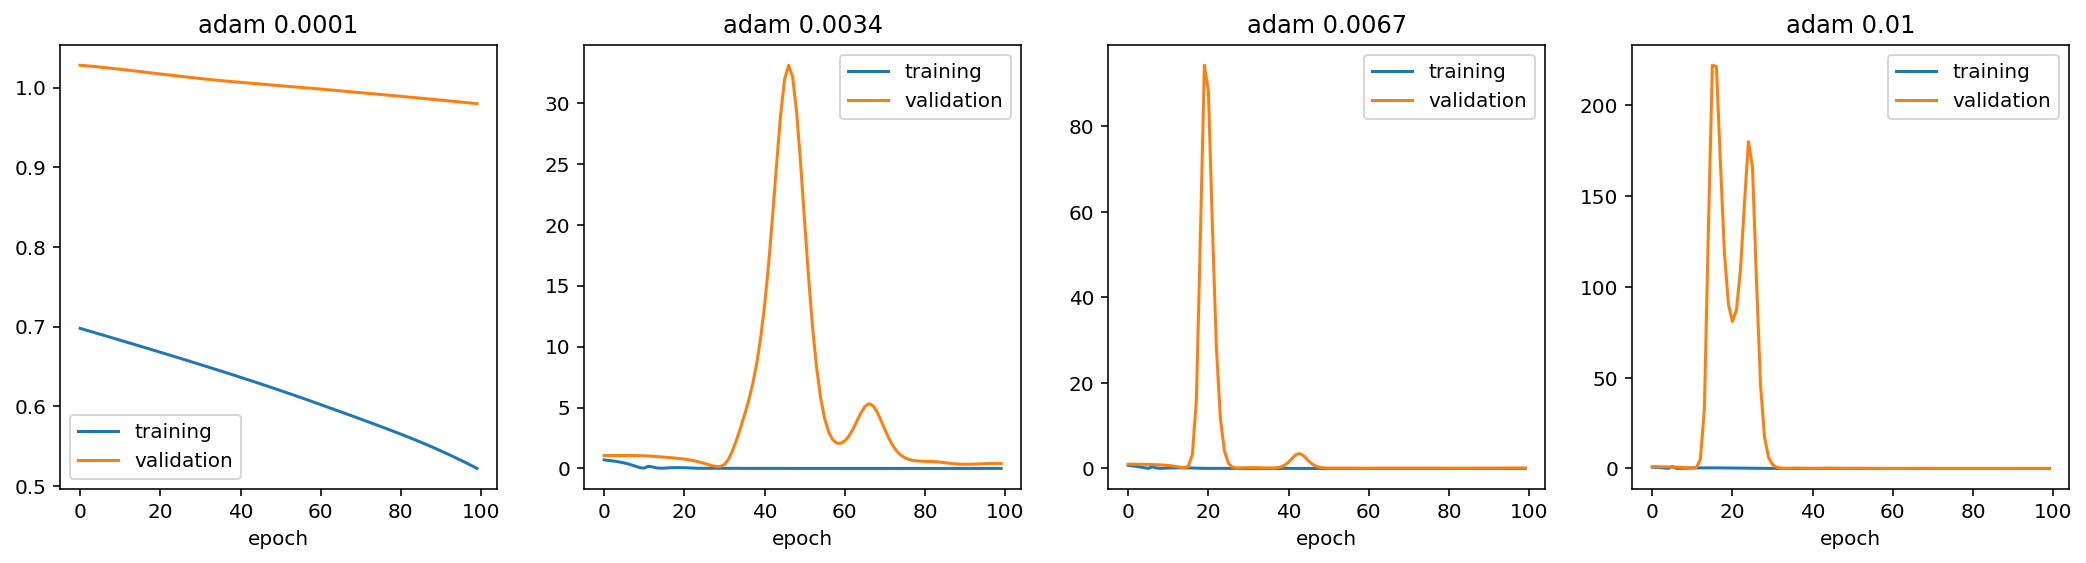

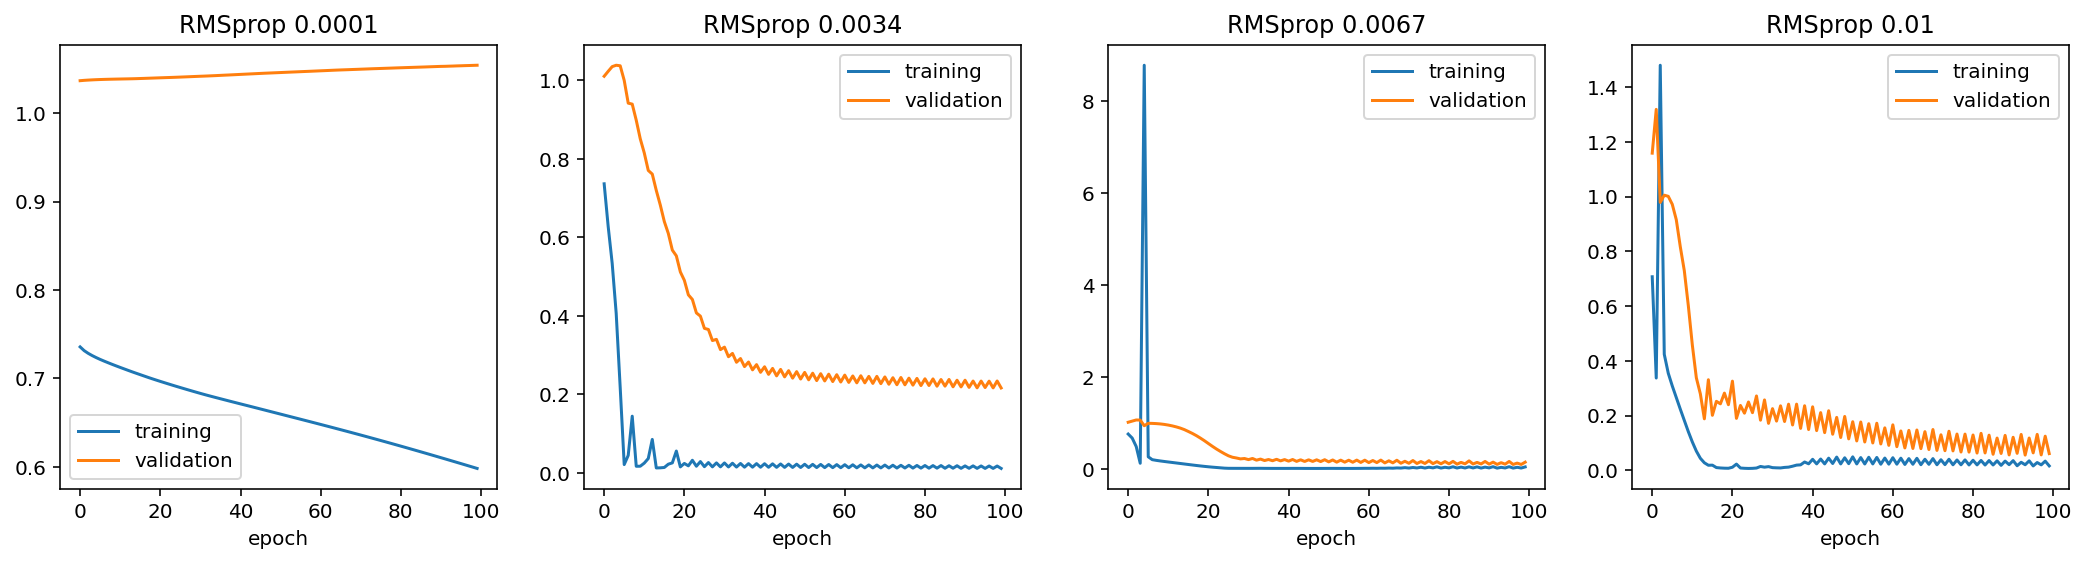

In [35]:
count = 0
for o in range(len(optimizers)):
  f, ax = plt.subplots(1, 4, figsize=(18,4), dpi=144)
  ax = ax.flatten()
  for r in range(len(learning_rate)):
      ax[r].plot(hist[count].history['loss'], label="training")
      ax[r].plot(hist[count].history['val_loss'], label="validation")
      ax[r].set_title(f"{optimizers[o]} {learning_rate[r].round(5)}")
      ax[r].set_xlabel("epoch")
      ax[r].legend()
      count = count + 1

  plt.show()

In [36]:
set_seeds()
hist = []
lstm_model1.compile(optimizer='RMSprop', loss='mse',  metrics=['mae'])
lstm_model1.optimizer.learning_rate = 0.01
reinitialize(lstm_model1)
history = lstm_model1.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=150)
hist.append(history)

Epoch 1/150
1/1 [==============================] - 3s 3s/step - loss: 0.7616 - mae: 0.7322 - val_loss: 1.1082 - val_mae: 1.0144
Epoch 2/150
1/1 [==============================] - 0s 45ms/step - loss: 0.3542 - mae: 0.5027 - val_loss: 1.2805 - val_mae: 1.1057
Epoch 3/150
1/1 [==============================] - 0s 81ms/step - loss: 2.6234 - mae: 1.4437 - val_loss: 1.0405 - val_mae: 0.9790
Epoch 4/150
1/1 [==============================] - 0s 50ms/step - loss: 0.4500 - mae: 0.5599 - val_loss: 1.0493 - val_mae: 0.9848
Epoch 5/150
1/1 [==============================] - 0s 44ms/step - loss: 0.3901 - mae: 0.5221 - val_loss: 1.0439 - val_mae: 0.9823
Epoch 6/150
1/1 [==============================] - 0s 45ms/step - loss: 0.3575 - mae: 0.5003 - val_loss: 1.0480 - val_mae: 0.9850
Epoch 7/150
1/1 [==============================] - 0s 46ms/step - loss: 0.3261 - mae: 0.4792 - val_loss: 1.0260 - val_mae: 0.9740
Epoch 8/150
1/1 [==============================] - 0s 46ms/step - loss: 0.2916 - mae: 0.4522

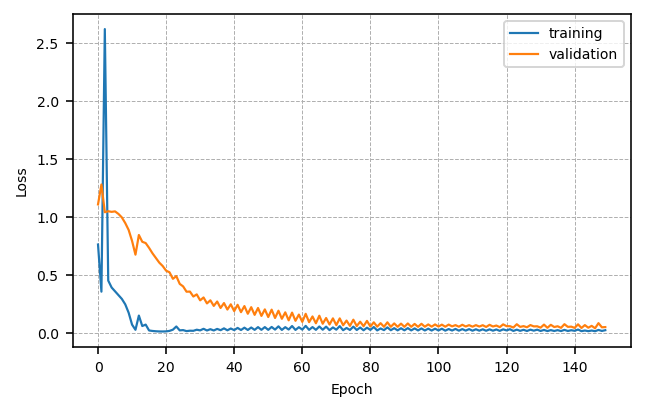

In [37]:
plt.figure(dpi=144, figsize=(5,3))
plt.plot(hist[0].history['loss'], label="training",
            linewidth = 1.1)
plt.plot(hist[0].history['val_loss'], label="validation",
          linewidth = 1.1)
plt.xlabel("Epoch", fontsize=7)
plt.ylabel("Loss", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

In [38]:
lstm_model1_forecast = lstm_model1.predict(x_test)

1/1 [==============================] - 0s 356ms/step


In [39]:
lstm_model1_mse = mean_squared_error(y_test, lstm_model1_forecast)
lstm_model1_rmse = np.sqrt(lstm_model1_mse)
lstm_model1_mape = mean_absolute_percentage_error(y_test, lstm_model1_forecast)
print("RMSE : ",lstm_model1_rmse)
print("MAPE : ",lstm_model1_mape)

RMSE :  0.219207767802606
MAPE :  0.2221759108453645


In [40]:
prediction_copy = np.repeat(lstm_model1_forecast, 3, axis=-1)
unscaled_lstm_model1_forecast = china_scaler.inverse_transform(prediction_copy)[:, 0]

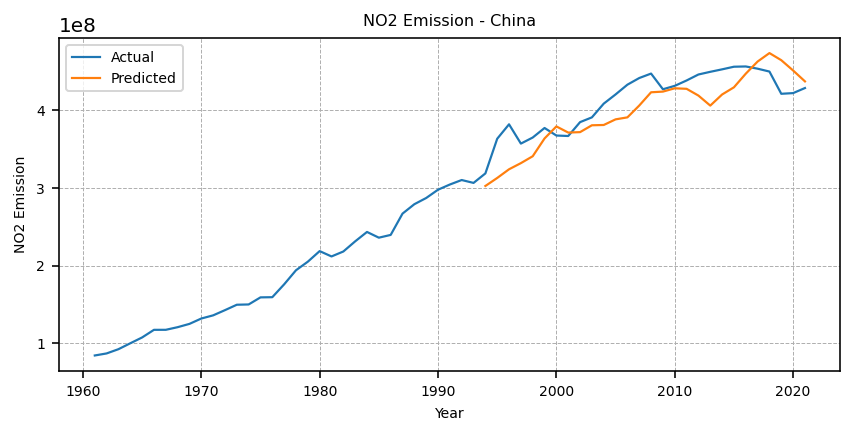

In [41]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(china_df.index, china_df.iloc[:, 0], label='Actual',
            linewidth = 1.1)
plt.plot(china_df.index[5+train_size:], unscaled_lstm_model1_forecast, label='Predicted',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - China", fontsize=8)
plt.show()

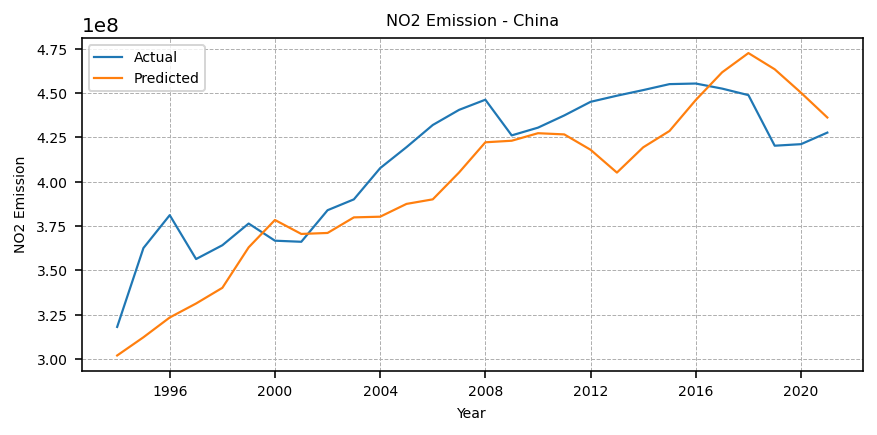

In [42]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(china_df.index[5+train_size:], china_df.iloc[5+train_size:, 0], label='Actual',
            linewidth = 1.1)
plt.plot(china_df.index[5+train_size:], unscaled_lstm_model1_forecast, label='Predicted',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - China", fontsize=8)
plt.show()

In [52]:
x, y = create_sequence(scaled_us_df, 5)

In [53]:
train_size = int(len(x)*0.5)
x_train, x_test = x[:train_size], x[train_size: ]
y_train, y_test = y[:train_size], y[train_size: ]

In [45]:
lstm_model2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    tf.keras.layers.LSTM(64, activation = 'relu', return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [46]:
optimizers = ['SGD', 'adam', 'RMSprop']
learning_rate = np.linspace(0.0001, 0.01, 4)
hist = []
for opt in optimizers:
  for rate in learning_rate:
      set_seeds()
      lstm_model2.compile(optimizer=opt, loss='mse',  metrics=['mae'])
      lstm_model2.optimizer.learning_rate = rate
      print("")
      print(f"optimizer: {opt}    learning rate: {rate}")
      print("")
      reinitialize(lstm_model2)
      history = lstm_model2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=100)
      hist.append(history)


optimizer: SGD    learning rate: 0.0001

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.1460 - mae: 0.9123 - val_loss: 0.0597 - val_mae: 0.1942
Epoch 2/100
1/1 [==============================] - 0s 67ms/step - loss: 1.1405 - mae: 0.9101 - val_loss: 0.0597 - val_mae: 0.1942
Epoch 3/100
1/1 [==============================] - 0s 46ms/step - loss: 1.1448 - mae: 0.9108 - val_loss: 0.0598 - val_mae: 0.1942
Epoch 4/100
1/1 [==============================] - 0s 49ms/step - loss: 1.1496 - mae: 0.9139 - val_loss: 0.0598 - val_mae: 0.1943
Epoch 5/100
1/1 [==============================] - 0s 45ms/step - loss: 1.1398 - mae: 0.9081 - val_loss: 0.0598 - val_mae: 0.1943
Epoch 6/100
1/1 [==============================] - 0s 46ms/step - loss: 1.1407 - mae: 0.9106 - val_loss: 0.0598 - val_mae: 0.1944
Epoch 7/100
1/1 [==============================] - 0s 61ms/step - loss: 1.1378 - mae: 0.9095 - val_loss: 0.0598 - val_mae: 0.1944
Epoch 8/100
1/1 [==============================] -

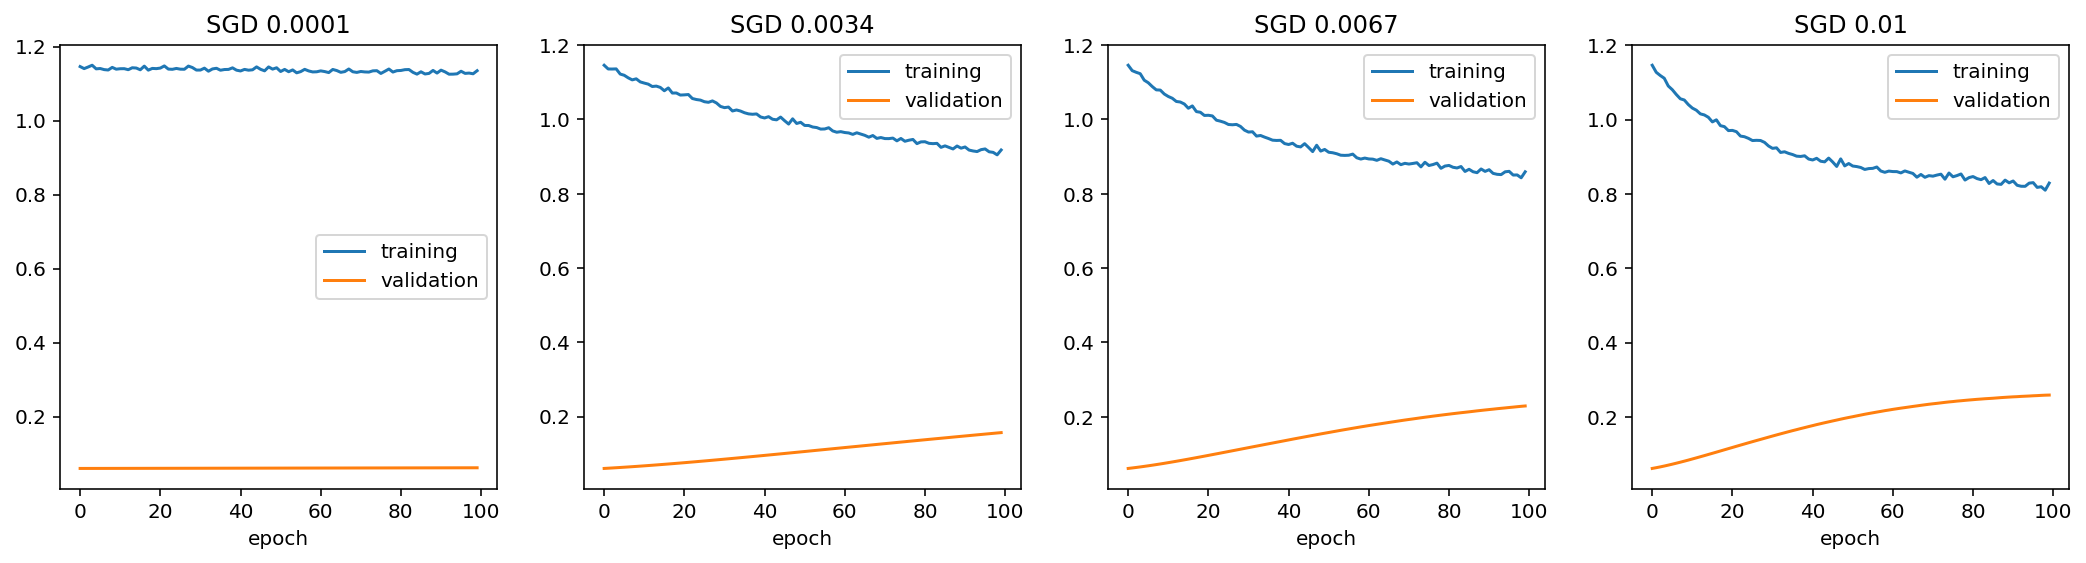

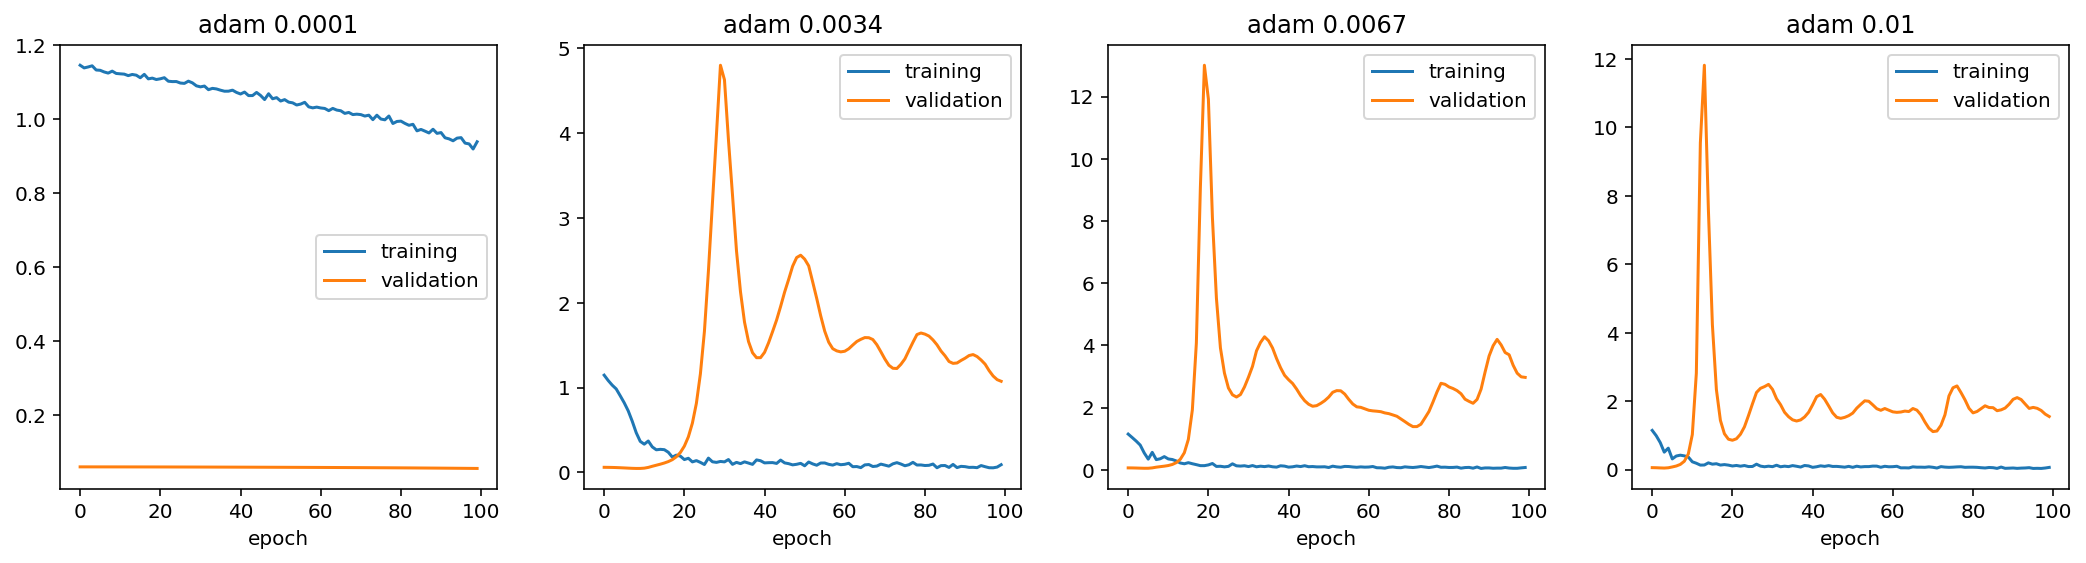

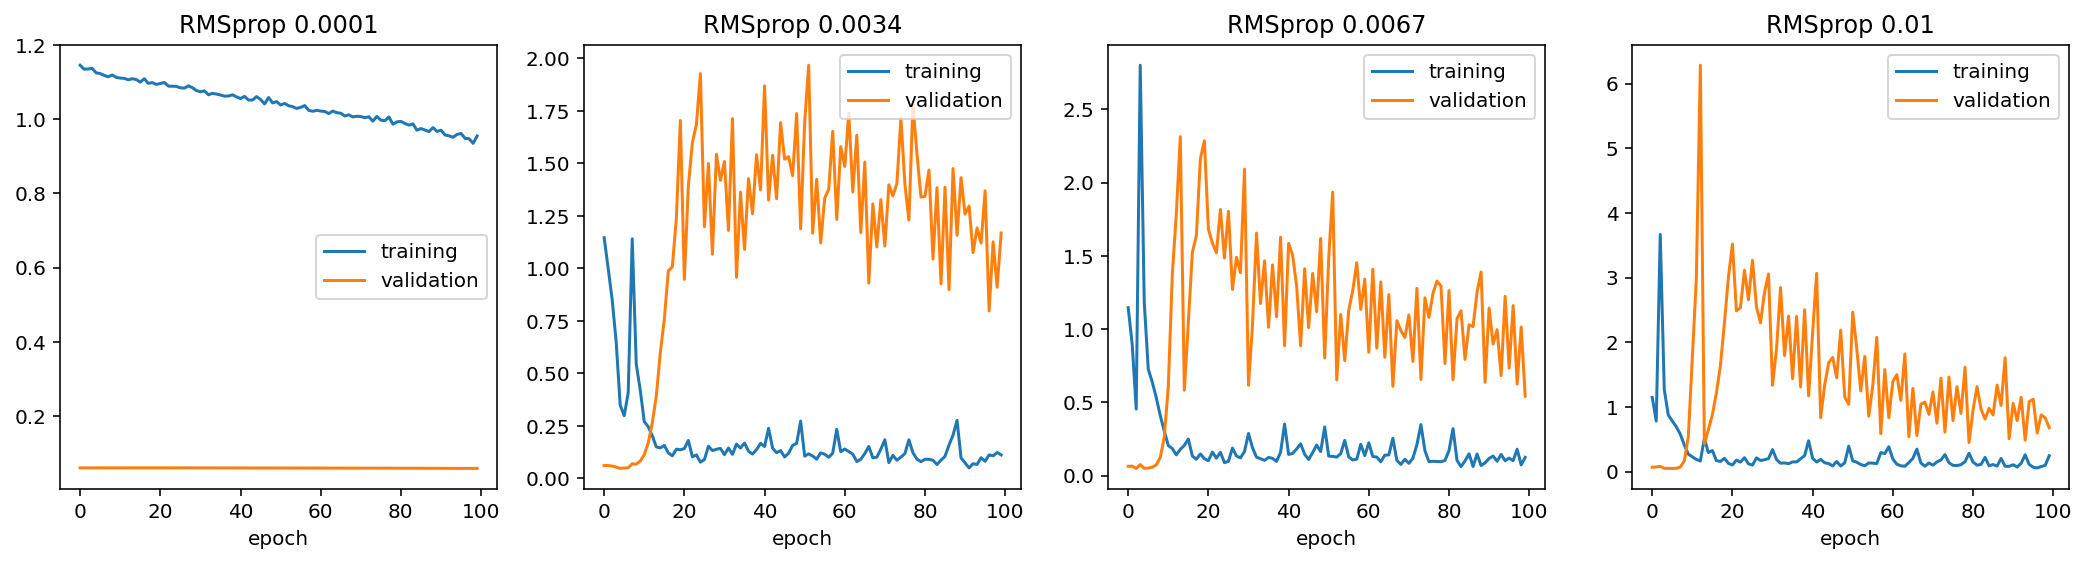

In [47]:
count = 0
for o in range(len(optimizers)):
  f, ax = plt.subplots(1, 4, figsize=(18,4), dpi=144)
  ax = ax.flatten()
  for r in range(len(learning_rate)):
      ax[r].plot(hist[count].history['loss'], label="training")
      ax[r].plot(hist[count].history['val_loss'], label="validation")
      ax[r].set_title(f"{optimizers[o]} {learning_rate[r].round(5)}")
      ax[r].set_xlabel("epoch")
      ax[r].legend()
      count = count + 1

  plt.show()

In [48]:
set_seeds()
hist = []
lstm_model2.compile(optimizer='RMSprop', loss='mse',  metrics=['mae'])
lstm_model2.optimizer.learning_rate = 0.01
reinitialize(lstm_model2)
history = lstm_model2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=250)
hist.append(history)

Epoch 1/250
1/1 [==============================] - 4s 4s/step - loss: 1.1460 - mae: 0.9123 - val_loss: 0.0665 - val_mae: 0.2101
Epoch 2/250
1/1 [==============================] - 0s 43ms/step - loss: 0.7802 - mae: 0.7509 - val_loss: 0.0698 - val_mae: 0.2185
Epoch 3/250
1/1 [==============================] - 0s 43ms/step - loss: 3.6672 - mae: 1.7880 - val_loss: 0.0786 - val_mae: 0.2216
Epoch 4/250
1/1 [==============================] - 0s 59ms/step - loss: 1.2679 - mae: 0.9402 - val_loss: 0.0489 - val_mae: 0.1723
Epoch 5/250
1/1 [==============================] - 0s 59ms/step - loss: 0.8754 - mae: 0.7957 - val_loss: 0.0480 - val_mae: 0.1712
Epoch 6/250
1/1 [==============================] - 0s 45ms/step - loss: 0.7815 - mae: 0.7536 - val_loss: 0.0474 - val_mae: 0.1705
Epoch 7/250
1/1 [==============================] - 0s 66ms/step - loss: 0.6919 - mae: 0.7033 - val_loss: 0.0494 - val_mae: 0.1704
Epoch 8/250
1/1 [==============================] - 0s 61ms/step - loss: 0.5775 - mae: 0.6490

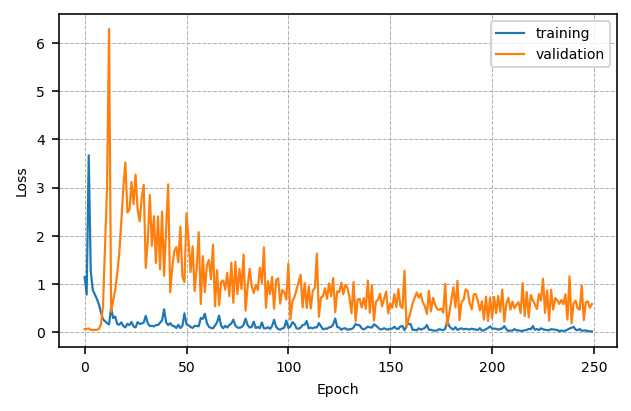

In [49]:

plt.figure(dpi=144, figsize=(5,3))
plt.plot(hist[0].history['loss'], label="training",
            linewidth = 1.1)
plt.plot(hist[0].history['val_loss'], label="validation",
          linewidth = 1.1)
plt.xlabel("Epoch", fontsize=7)
plt.ylabel("Loss", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

In [50]:
lstm_model2_forecast = lstm_model2.predict(x_test)

1/1 [==============================] - 0s 302ms/step


In [51]:
lstm_model2_mse = mean_squared_error(y_test, lstm_model2_forecast)
lstm_model2_rmse = np.sqrt(lstm_model2_mse)
lstm_model2_mape = mean_absolute_percentage_error(y_test, lstm_model2_forecast)
print("RMSE : ",lstm_model2_rmse)
print("MAPE : ",lstm_model2_mape)

RMSE :  0.7636032230432058
MAPE :  7.324922231121103


In [52]:
prediction_copy = np.repeat(lstm_model2_forecast, 3, axis=-1)
unscaled_lstm_model2_forecast = us_scaler.inverse_transform(prediction_copy)[:, 0]

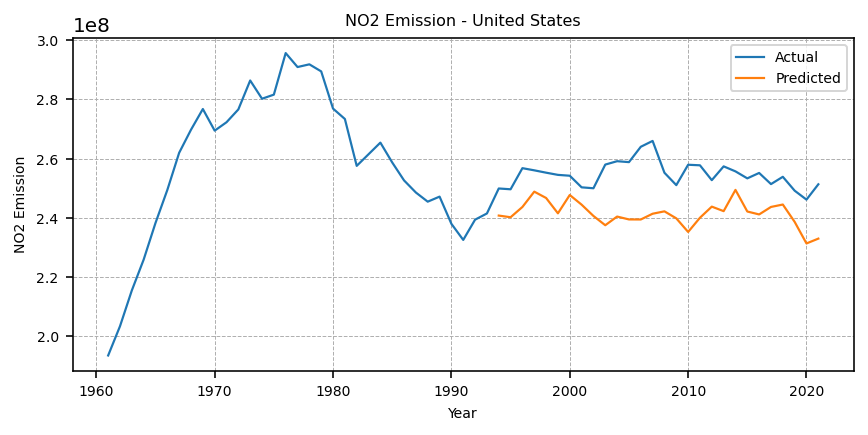

In [53]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(us_df.index, us_df.iloc[:, 0], label='Actual',
            linewidth = 1.1)
plt.plot(us_df.index[5+train_size:], unscaled_lstm_model2_forecast, label='Predicted',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - United States", fontsize=8)
plt.show()

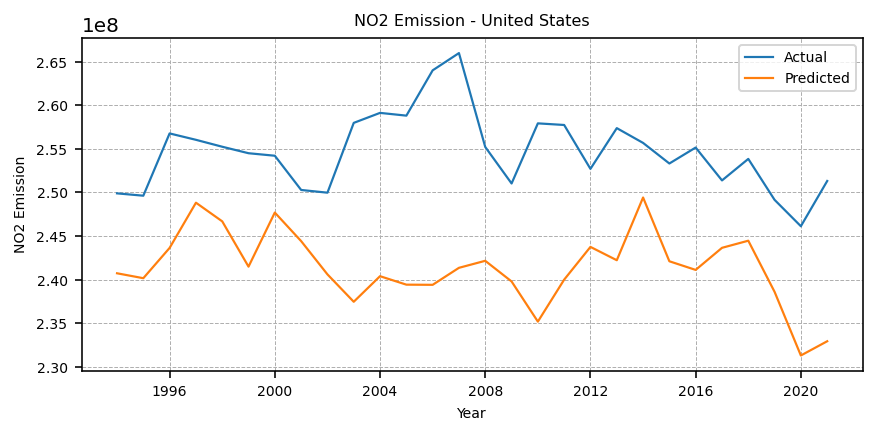

In [54]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(us_df.index[5+train_size:], us_df.iloc[5+train_size:, 0], label='Actual',
            linewidth = 1.1)
plt.plot(us_df.index[5+train_size:], unscaled_lstm_model2_forecast, label='Predicted',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - United States", fontsize=8)
plt.show()

In [57]:
avg_eml_model1_forecast = (sarimax_model1_forecast[3: ] + lstm_model1_forecast)/2

In [94]:
avg_eml_model1_mse = mean_squared_error(y_test, avg_eml_model1_forecast)
avg_eml_model1_rmse = np.sqrt(avg_eml_model1_mse)
avg_eml_model1_mape = mean_absolute_percentage_error(y_test, avg_eml_model1_forecast)
print("RMSE : ",avg_eml_model1_rmse)
print("MAPE : ",avg_eml_model1_mape)

RMSE :  0.7871258431682957
MAPE :  6.823625806414712


In [58]:
prediction_copy = np.repeat(avg_eml_model1_forecast, 3, axis=-1)
unscaled_avg_eml_model1_forecast = china_scaler.inverse_transform(prediction_copy)[:, 0]

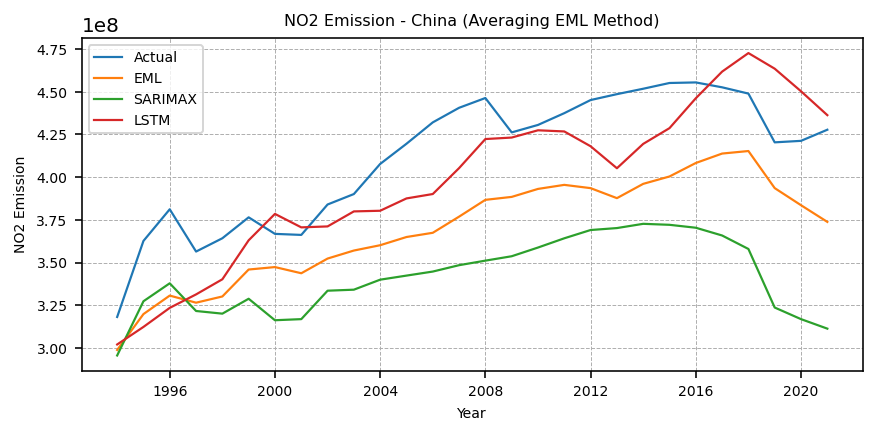

In [78]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(china_df.index[5+train_size:], china_df.iloc[5+train_size:, 0], label='Actual',
            linewidth = 1.1)
plt.plot(china_df.index[5+train_size:], unscaled_avg_eml_model1_forecast, label='EML',
          linewidth = 1.1)
plt.plot(china_df.index[5+train_size:], unscaled_sarimax_model1_forecast[3:], label='SARIMAX',
          linewidth = 1.1)
plt.plot(china_df.index[5+train_size:], unscaled_lstm_model1_forecast, label='LSTM',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - China (Averaging EML Method)", fontsize=8)
plt.show()

In [63]:
avg_eml_model2_forecast = (sarimax_model2_forecast[3:] + lstm_model2_forecast) / 2

In [93]:
avg_eml_model2_mse = mean_squared_error(y_test, avg_eml_model2_forecast)
avg_eml_model2_rmse = np.sqrt(avg_eml_model2_mse)
avg_eml_model2_mape = mean_absolute_percentage_error(y_test, avg_eml_model2_forecast)
print("RMSE : ",avg_eml_model2_rmse)
print("MAPE : ",avg_eml_model2_mape)

RMSE :  0.4392229938755073
MAPE :  5.042884384687021


In [64]:
prediction_copy = np.repeat(avg_eml_model2_forecast, 3, axis=-1)
unscaled_avg_eml_model2_forecast = us_scaler.inverse_transform(prediction_copy)[:, 0]

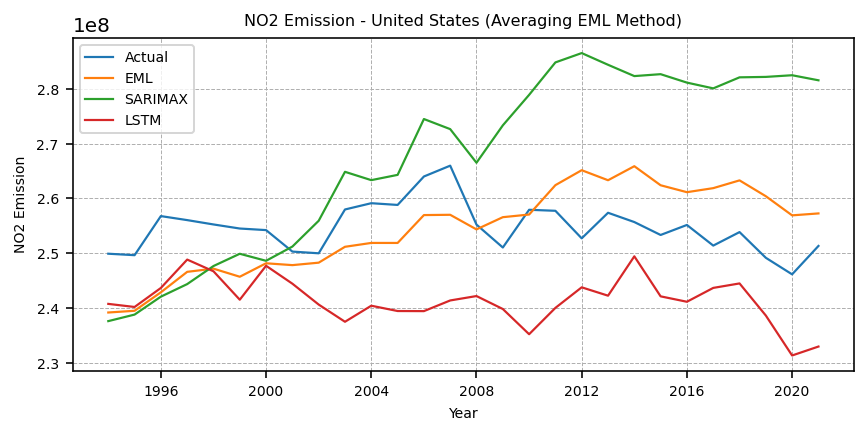

In [77]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(us_df.index[5+train_size:], us_df.iloc[5+train_size:, 0], label='Actual',
            linewidth = 1.1)
plt.plot(us_df.index[5+train_size:], unscaled_avg_eml_model2_forecast, label='EML',
          linewidth = 1.1)
plt.plot(us_df.index[5+train_size:], unscaled_sarimax_model2_forecast[3:], label='SARIMAX',
          linewidth = 1.1)
plt.plot(us_df.index[5+train_size:], unscaled_lstm_model2_forecast, label='LSTM',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - United States (Averaging EML Method)", fontsize=8)
plt.show()

In [69]:
stacked_model1_forecast = np.column_stack((sarimax_model1_forecast[3:], lstm_model1_forecast))

In [70]:
meta_model = LinearRegression()
meta_model.fit(stacked_model1_forecast, scaled_china_df[5+train_size :, 0])

LinearRegression()

In [72]:
stack_eml_model1_forecast = meta_model.predict(stacked_model1_forecast).reshape(stacked_model1_forecast.shape[0], -1)

In [97]:
stack_eml_model1_mse = mean_squared_error(scaled_china_df[5+train_size :, 0], stack_eml_model1_forecast)
stack_eml_model1_rmse = np.sqrt(stack_eml_model1_mse)
stack_eml_model1_mape = mean_absolute_percentage_error(scaled_china_df[5+train_size :, 0], stack_eml_model1_forecast)
print("RMSE : ",stack_eml_model1_rmse)
print("MAPE : ",stack_eml_model1_mape)

RMSE :  0.08428827743491588
MAPE :  0.08330623125459947


In [74]:
prediction_copy = np.repeat(stack_eml_model1_forecast, 3, axis=-1)
unscaled_stack_eml_model1_forecast = china_scaler.inverse_transform(prediction_copy)[:, 0]

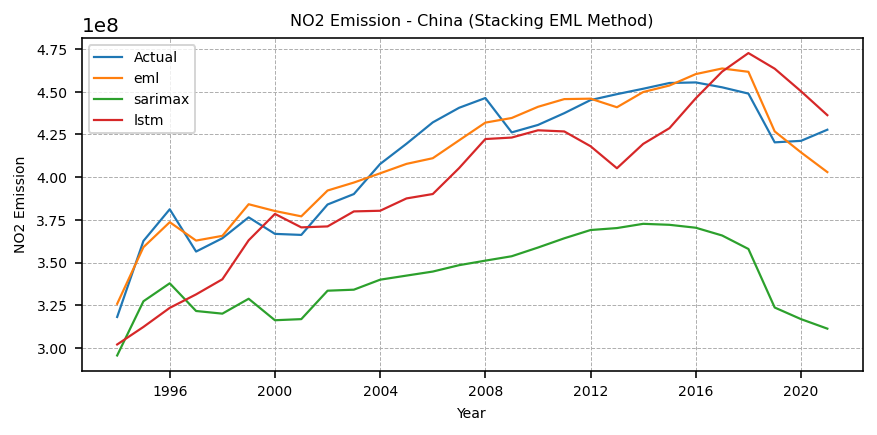

In [76]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(china_df.index[5+train_size:], china_df.iloc[5+train_size:, 0], label='Actual',
            linewidth = 1.1)
plt.plot(china_df.index[5+train_size:], unscaled_stack_eml_model1_forecast, label='eml',
          linewidth = 1.1)
plt.plot(china_df.index[5+train_size:], unscaled_sarimax_model1_forecast[3:], label='sarimax',
          linewidth = 1.1)
plt.plot(china_df.index[5+train_size:], unscaled_lstm_model1_forecast, label='lstm',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - China (Stacking EML Method)", fontsize=8)
plt.show()

In [79]:
stacked_model2_forecast = np.column_stack((sarimax_model2_forecast[3:], lstm_model2_forecast))

In [80]:
meta_model = LinearRegression()
meta_model.fit(stacked_model2_forecast, scaled_us_df[5+train_size :, 0])

LinearRegression()

In [81]:
stack_eml_model2_forecast = meta_model.predict(stacked_model2_forecast).reshape(stacked_model2_forecast.shape[0], -1)

In [96]:
stack_eml_model2_mse = mean_squared_error(scaled_us_df[5+train_size :, 0], stack_eml_model2_forecast)
stack_eml_model2_rmse = np.sqrt(stack_eml_model2_mse)
stack_eml_model2_mape = mean_absolute_percentage_error(scaled_us_df[5+train_size :, 0], stack_eml_model2_forecast)
print("RMSE : ",stack_eml_model2_rmse)
print("MAPE : ",stack_eml_model2_mape)

RMSE :  0.22667066490038734
MAPE :  1.2697443342228578


In [82]:
prediction_copy = np.repeat(stack_eml_model2_forecast, 3, axis=-1)
unscaled_stack_eml_model2_forecast = us_scaler.inverse_transform(prediction_copy)[:, 0]

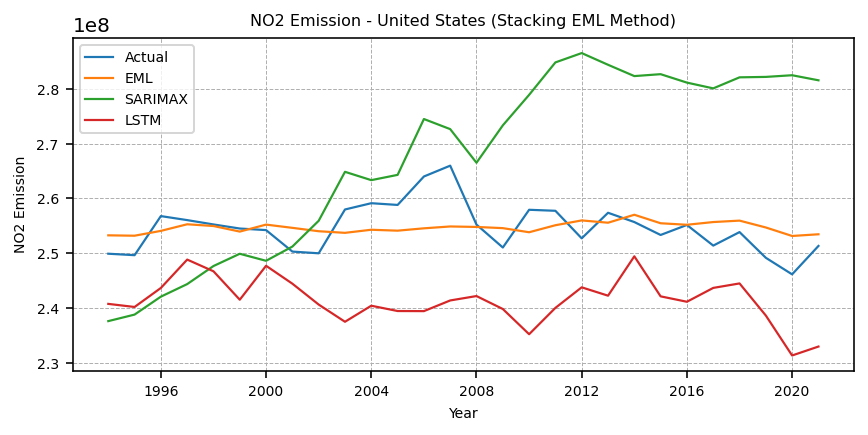

In [84]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(us_df.index[5+train_size:], us_df.iloc[5+train_size:, 0], label='Actual',
            linewidth = 1.1)
plt.plot(us_df.index[5+train_size:], unscaled_stack_eml_model2_forecast, label='EML',
          linewidth = 1.1)
plt.plot(us_df.index[5+train_size:], unscaled_sarimax_model2_forecast[3:], label='SARIMAX',
          linewidth = 1.1)
plt.plot(us_df.index[5+train_size:], unscaled_lstm_model2_forecast, label='LSTM',
          linewidtplth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - United States (Stacking EML Method)", fontsize=8)
plt.show()

In [59]:
xtrain,xtest = train_test_split(scaled_china_df)


In [60]:
optimal_model = auto_model(xtrain)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-76.581, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.755, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.823, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-79.913, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.988, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.68 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.649 seconds


In [61]:
order = optimal_model.order
seasonal_order = optimal_model.seasonal_order


In [64]:
print(xtrain.shape)

(30, 3)


In [65]:
print(xtest[0, :].reshape(1,3))

[[ 0.10482195  0.23474472 -0.15200596]]


In [66]:
openloop_sarimax_model1_forecast = []
for i in range(1,len(xtest)+1):
  model = sarimax_model(xtrain, order, seasonal_order)
  model_fit = model.fit()
  prediction = model_fit.forecast(steps=1,
                             exog=xtest[i-1, 1:])
  openloop_sarimax_model1_forecast.append(prediction)
  xtrain = np.concatenate((xtrain, xtest[i-1, :].reshape(1,3)), axis=0)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [68]:
openloop_sarimax_model1_forecast = [item for array in openloop_sarimax_model1_forecast for item in array]
openloop_sarimax_model1_forecast = np.array(openloop_sarimax_model1_forecast).reshape(len(openloop_sarimax_model1_forecast), -1)

In [69]:
prediction_copy = np.repeat(openloop_sarimax_model1_forecast, 3, axis=-1)
unscaled_openloop_sarimax_model1_forecast = china_scaler.inverse_transform(prediction_copy)[:, 0]

28


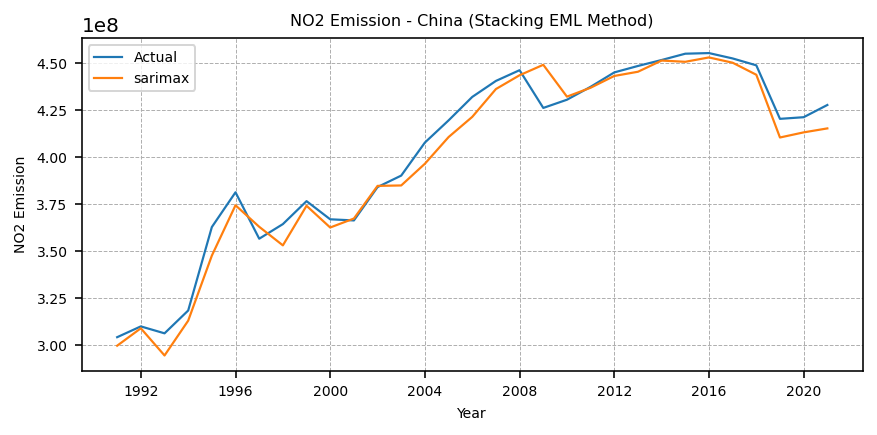

In [70]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(china_df.index[30:], china_df.iloc[30:, 0], label='Actual',
            linewidth = 1.1)
plt.plot(china_df.index[30:], unscaled_openloop_sarimax_model1_forecast, label='sarimax',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - China (Stacking EML Method)", fontsize=8)
plt.show()

In [71]:
x, y = create_sequence(scaled_china_df, 5)

In [72]:
train_size = int(len(x)*0.5)
x_train, x_test = x[:train_size], x[train_size: ]
y_train, y_test = y[:train_size], y[train_size: ]

In [95]:
openloop_lstm_model1_forecast = []
for i in range (1, len(x_test)+1):
  set_seeds()
  lstm_model1.compile(optimizer='RMSprop', loss='mse',  metrics=['mae'])
  lstm_model1.optimizer.learning_rate = 0.01
  reinitialize(lstm_model1)
  lstm_model1.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=150)
  prediction = lstm_model1.predict(x_test[i-1, : ].reshape(1, 5, 3))
  openloop_lstm_model1_forecast.append(prediction)
  x_train = np.concatenate((x_train, x_test[i-1, : ].reshape(1, 5, 3)), axis=0)
  y_train = np.concatenate((y_train, y_test[i-1].reshape(1)), axis=0)

Epoch 1/150
1/1 [==============================] - 34s 34s/step - loss: 0.7616 - mae: 0.7322 - val_loss: 1.1082 - val_mae: 1.0144
Epoch 2/150
1/1 [==============================] - 0s 40ms/step - loss: 0.3542 - mae: 0.5027 - val_loss: 1.2805 - val_mae: 1.1057
Epoch 3/150
1/1 [==============================] - 0s 38ms/step - loss: 2.6234 - mae: 1.4437 - val_loss: 1.0405 - val_mae: 0.9790
Epoch 4/150
1/1 [==============================] - 0s 58ms/step - loss: 0.4500 - mae: 0.5599 - val_loss: 1.0493 - val_mae: 0.9848
Epoch 5/150
1/1 [==============================] - 0s 38ms/step - loss: 0.3901 - mae: 0.5221 - val_loss: 1.0439 - val_mae: 0.9823
Epoch 6/150
1/1 [==============================] - 0s 43ms/step - loss: 0.3575 - mae: 0.5003 - val_loss: 1.0480 - val_mae: 0.9850
Epoch 7/150
1/1 [==============================] - 0s 40ms/step - loss: 0.3261 - mae: 0.4792 - val_loss: 1.0260 - val_mae: 0.9740
Epoch 8/150
1/1 [==============================] - 0s 63ms/step - loss: 0.2916 - mae: 0.45

1/1 [==============================] - 0s 451ms/step
Epoch 1/150
1/1 [==============================] - 3s 3s/step - loss: 0.7029 - mae: 0.7043 - val_loss: 1.0696 - val_mae: 0.9957
Epoch 2/150
1/1 [==============================] - 0s 86ms/step - loss: 0.3680 - mae: 0.5199 - val_loss: 1.0873 - val_mae: 1.0142
Epoch 3/150
1/1 [==============================] - 0s 73ms/step - loss: 1.5261 - mae: 1.1076 - val_loss: 0.8321 - val_mae: 0.8701
Epoch 4/150
1/1 [==============================] - 0s 61ms/step - loss: 0.4702 - mae: 0.5727 - val_loss: 0.8374 - val_mae: 0.8767
Epoch 5/150
1/1 [==============================] - 0s 73ms/step - loss: 0.3768 - mae: 0.5118 - val_loss: 0.7508 - val_mae: 0.8299
Epoch 6/150
1/1 [==============================] - 0s 45ms/step - loss: 0.3392 - mae: 0.4841 - val_loss: 0.6092 - val_mae: 0.7471
Epoch 7/150
1/1 [==============================] - 0s 59ms/step - loss: 0.2999 - mae: 0.4519 - val_loss: 0.3950 - val_mae: 0.5998
Epoch 8/150
1/1 [======================

Streaming output truncated to the last 5000 lines.
Epoch 60/150
2/2 [==============================] - 0s 56ms/step - loss: 0.0218 - mae: 0.1184 - val_loss: 0.3306 - val_mae: 0.5469
Epoch 61/150
2/2 [==============================] - 0s 55ms/step - loss: 0.0457 - mae: 0.1675 - val_loss: 0.0139 - val_mae: 0.0993
Epoch 62/150
2/2 [==============================] - 0s 92ms/step - loss: 0.0112 - mae: 0.0870 - val_loss: 0.1360 - val_mae: 0.3362
Epoch 63/150
2/2 [==============================] - 0s 75ms/step - loss: 0.0441 - mae: 0.1777 - val_loss: 0.0137 - val_mae: 0.0959
Epoch 64/150
2/2 [==============================] - 0s 71ms/step - loss: 0.0142 - mae: 0.0983 - val_loss: 0.0321 - val_mae: 0.1503
Epoch 65/150
2/2 [==============================] - 0s 63ms/step - loss: 0.0559 - mae: 0.2060 - val_loss: 0.0955 - val_mae: 0.2802
Epoch 66/150
2/2 [==============================] - 0s 75ms/step - loss: 0.1048 - mae: 0.2770 - val_loss: 0.1405 - val_mae: 0.3484
Epoch 67/150
2/2 [==============

In [97]:
openloop_lstm_model1_forecast = [item for array in openloop_lstm_model1_forecast for item in array]
openloop_lstm_model1_forecast = np.array(openloop_lstm_model1_forecast).reshape(len(openloop_lstm_model1_forecast), -1)

In [100]:
prediction_copy = np.repeat(openloop_lstm_model1_forecast, 3, axis=-1)
unscaled_openloop_lstm_model1_forecast = china_scaler.inverse_transform(prediction_copy)[:, 0]

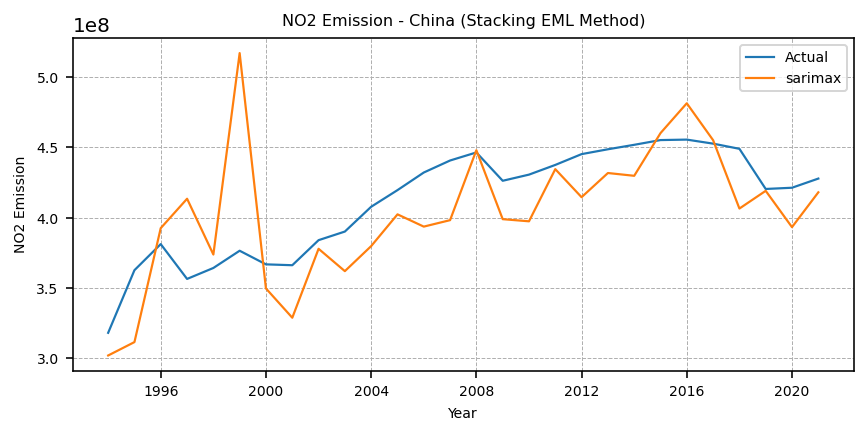

In [102]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(china_df.index[33:], china_df.iloc[33:, 0], label='Actual',
            linewidth = 1.1)
plt.plot(china_df.index[33:], unscaled_openloop_lstm_model1_forecast, label='sarimax',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - China (Stacking EML Method)", fontsize=8)
plt.show()

In [103]:
stacked_openloop_model1_forecast = np.column_stack((openloop_sarimax_model1_forecast[3:], openloop_lstm_model1_forecast))

In [104]:
meta_model = LinearRegression()
meta_model.fit(stacked_openloop_model1_forecast, scaled_china_df[33:, 0])

LinearRegression()

In [105]:
openloop_eml_model1_forecast = meta_model.predict(stacked_openloop_model1_forecast).reshape(stacked_openloop_model1_forecast.shape[0], -1)

In [107]:
prediction_copy = np.repeat(openloop_eml_model1_forecast, 3, axis=-1)
unscaled_openloop_eml_model1_forecast= china_scaler.inverse_transform(prediction_copy)[:, 0]

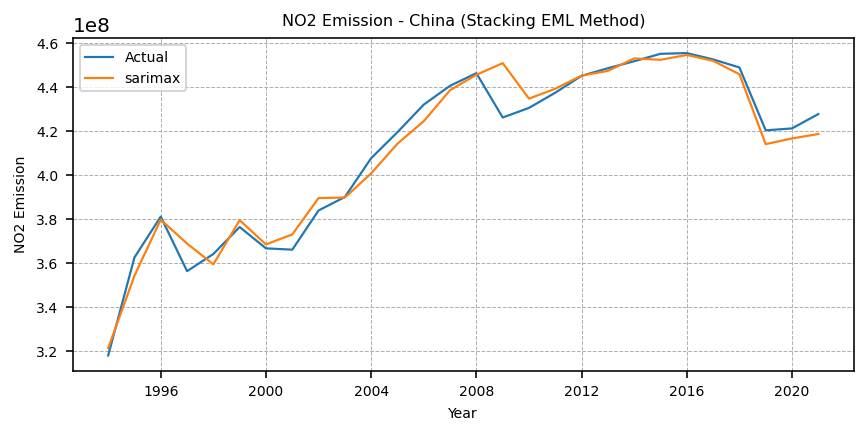

In [108]:
plt.figure(dpi=144, figsize=(7,3))
plt.plot(china_df.index[33:], china_df.iloc[33:, 0], label='Actual',
            linewidth = 1.1)
plt.plot(china_df.index[33:], unscaled_openloop_eml_model1_forecast, label='sarimax',
          linewidth = 1.1)
plt.xlabel("Year", fontsize=7)
plt.ylabel("NO2 Emission", fontsize=7)
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title("NO2 Emission - China (Stacking EML Method)", fontsize=8)
plt.show()